# ▒ 악어 이름 예측 ▒


*   문제정의: 악어 데이터셋을 이용하여 악어류의 종을 구분할 수 있는 모델 구축
*   데이터셋:
      *   이름: crocodile_dataset.csv
      *   주요 변수: Lenght, Weight, Habitat Type, Country/Region, Date of Observation, Scientific Name
*   목표:
      * 데이터 탐색을 통해 종별 생태적 특성 파악
      * 로그 변환 및 인코딩 등 전처리를 통한 모델 성능 향상
      * 변수 중요도 분석으로 종 구분에 영향을 주는 주요 요인 도출
*   핵심 질문:
      * 어떤 변수들이 악어 종 분류에 가장 큰 영향을 미치는가?
      * 보전 상태나 서식지가 분류에 의미 있는 요소인가?

## 1. 데이터 준비

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv("/content/gdrive/MyDrive/data/crocodile_dataset.csv", index_col="Observation ID")
print("데이터셋 크기:", df.shape)
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
데이터셋 크기: (1000, 14)


,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
Observation ID,,,,,,,,,,,,,,
1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...


* 샘플 수가 많지 않아 교차검증(K-Fold)을 활용할 필요가 있어 보임
* Obsever Name/Notes는 식별 정보 또는 비정형 텍스트로 모델링에는 불필요함. 따라서 분석에서 제외 가능
* Date of Observation은 계절성 변수로 파생 가능

## 2. 데이터 탐색(EDA)

In [19]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Common Name           1000 non-null   object 
 1   Scientific Name       1000 non-null   object 
 2   Family                1000 non-null   object 
 3   Genus                 1000 non-null   object 
 4   Observed Length (m)   1000 non-null   float64
 5   Observed Weight (kg)  1000 non-null   float64
 6   Age Class             1000 non-null   object 
 7   Sex                   1000 non-null   object 
 8   Date of Observation   1000 non-null   object 
 9   Country/Region        1000 non-null   object 
 10  Habitat Type          1000 non-null   object 
 11  Conservation Status   1000 non-null   object 
 12  Observer Name         1000 non-null   object 
 13  Notes                 1000 non-null   object 
dtypes: float64(2), object(12)
memory usage: 117.2+ KB
None


* 전처리에서 결측값 보정 작업 불필요

In [20]:
print("\n컬럼별 데이터 타입:")
print(df.dtypes)


컬럼별 데이터 타입:
Common Name              object
Scientific Name          object
Family                   object
Genus                    object
Observed Length (m)     float64
Observed Weight (kg)    float64
Age Class                object
Sex                      object
Date of Observation      object
Country/Region           object
Habitat Type             object
Conservation Status      object
Observer Name            object
Notes                    object
dtype: object


* 이 데이터셋은 범주형 변수가 다수로 모델링 시 One-Hot Encoding 또는 Label Encoding이 필요해 보임
* 수치형 + 범주형 혼합 구조로 Tree 기반 모델이 적합

In [21]:
print(df.describe(include="all"))

                 Common Name          Scientific Name        Family  \
count                   1000                     1000          1000   
unique                    18                       18             1   
top     New Guinea Crocodile  Crocodylus novaeguineae  Crocodylidae   
freq                      68                       68          1000   
mean                     NaN                      NaN           NaN   
std                      NaN                      NaN           NaN   
min                      NaN                      NaN           NaN   
25%                      NaN                      NaN           NaN   
50%                      NaN                      NaN           NaN   
75%                      NaN                      NaN           NaN   
max                      NaN                      NaN           NaN   

             Genus  Observed Length (m)  Observed Weight (kg) Age Class  \
count         1000          1000.000000           1000.000000      1000 

In [22]:
print(df.isnull().sum())

Common Name             0
Scientific Name         0
Family                  0
Genus                   0
Observed Length (m)     0
Observed Weight (kg)    0
Age Class               0
Sex                     0
Date of Observation     0
Country/Region          0
Habitat Type            0
Conservation Status     0
Observer Name           0
Notes                   0
dtype: int64


/tmp/ipython-input-2789561947.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Scientific Name", data=df, order=df["Scientific Name"].value_counts().index, palette="viridis")


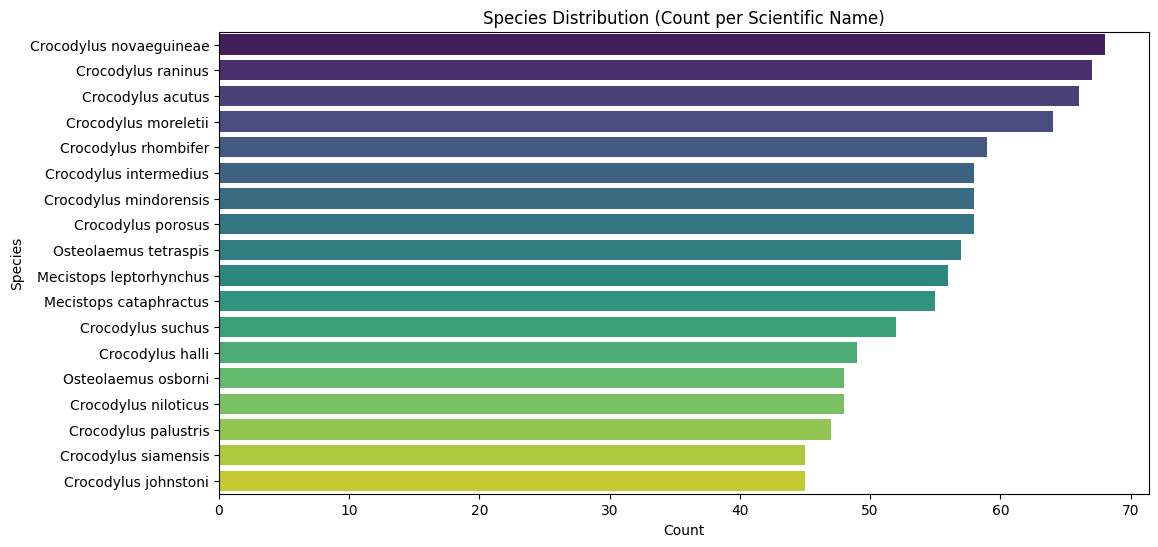

In [23]:
# 1. 종별 샘플 수 확인

plt.figure(figsize=(12,6))
sns.countplot(y="Scientific Name", data=df, order=df["Scientific Name"].value_counts().index, palette="viridis")
plt.title("Species Distribution (Count per Scientific Name)")
plt.xlabel("Count")
plt.ylabel("Species")
plt.show()

* 전체적으로 대부분의 종이 40~70여개의 샘플을 가지고 있어 클래스 불균형이 심하지 않음 -> 분류 모델(Random Forest, XGBoost)을 학습할 때 유리함
* 종별로 데이터 수가차이나는 이유는 단순한 수집 편향 뿐 아니라 실제 서식 지역의 접근성, 관찰 가능성, 보호 등급 등과도 연관될 수 있음 -> Species Count vs Conservation Status 상관분석을 하며 보전 상태가 관측 빈도에 영향을 주는지 확인 가능

/tmp/ipython-input-3598514314.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


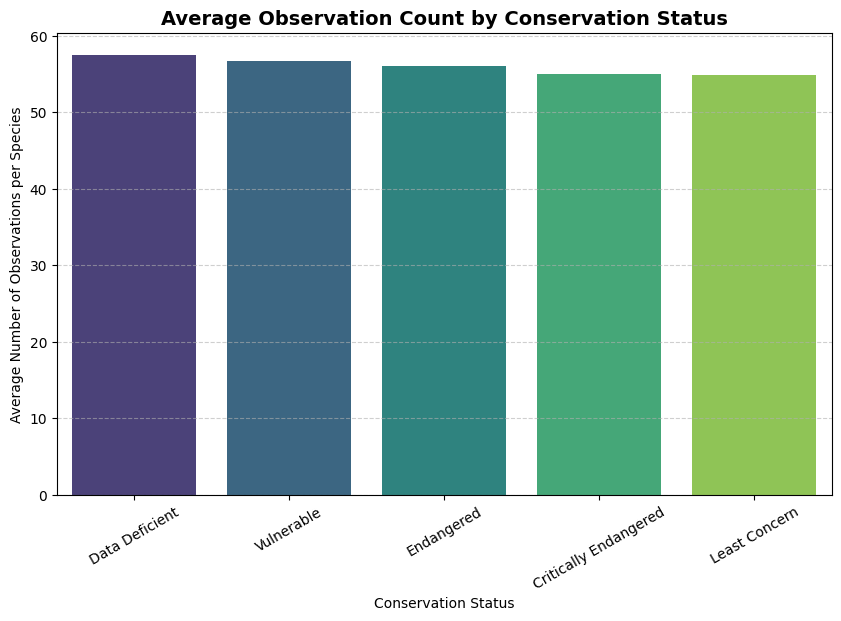

보전 상태별 평균 관찰 개수:
     Conservation Status      Count
1         Data Deficient  57.500000
4             Vulnerable  56.666667
2             Endangered  56.000000
0  Critically Endangered  55.000000
3          Least Concern  54.857143


In [24]:
# 2. Species Count vs Conservation Status

# 종별 데이터 개수 집계
species_counts = df['Scientific Name'].value_counts().reset_index()
species_counts.columns = ['Scientific Name', 'Count']

# 각 종의 보전 상태(Conservation Status)와 결합
species_status = df[['Scientific Name', 'Conservation Status']].drop_duplicates()
species_summary = pd.merge(species_counts, species_status, on='Scientific Name', how='left')

# 보전 상태별 평균 관찰 개수 계산
status_summary = species_summary.groupby('Conservation Status')['Count'].mean().reset_index()

# 시각화
plt.figure(figsize=(10,6))
sns.barplot(
    data=status_summary.sort_values('Count', ascending=False),
    x='Conservation Status',
    y='Count',
    palette='viridis'
)
plt.title('Average Observation Count by Conservation Status', fontsize=14, weight='bold')
plt.xlabel('Conservation Status')
plt.ylabel('Average Number of Observations per Species')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("보전 상태별 평균 관찰 개수:")
print(status_summary.sort_values('Count', ascending=False))

* 보전 상태 별로 거의 큰 차이가 없지만 미세하게 보전 상태가 좋을수록 평균 관찰 개수가 줄어드는 경향을 보임
* 종별 데이터 빈도는 보전 상태와 직접적인 음의 상관관계를 보이지 않음

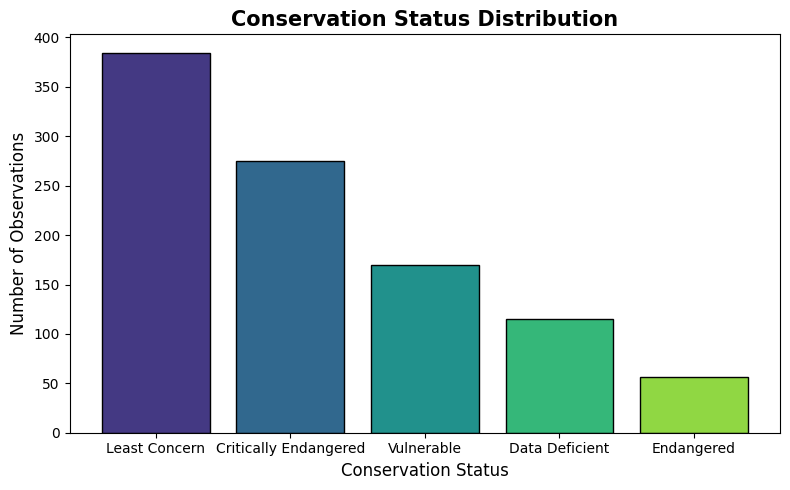

In [25]:
# 3. 보존 상태 분포

colors = sns.color_palette("viridis", n_colors=len(df['Conservation Status'].unique()))

status_counts = df['Conservation Status'].value_counts()

plt.figure(figsize=(8,5))
bars = plt.bar(status_counts.index, status_counts.values, color=colors, edgecolor='black', linewidth=1)

plt.title('Conservation Status Distribution', fontsize=15, weight='bold')
plt.xlabel('Conservation Status', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)

plt.tight_layout()
plt.show()

* Least Concern 범주가 가장 많이 관찰되고 Endanger가 가장 적게 관찰됨 -> 데이터 불균형 존재
* 보전 상태가 불균형하게 분포되어 있기때문에 이후 학습 데이터가 종 예측 시 특정 보전 상태에 편향될 가능성이 있음 -> 필요시 불균형 보정 기법 적용 고려

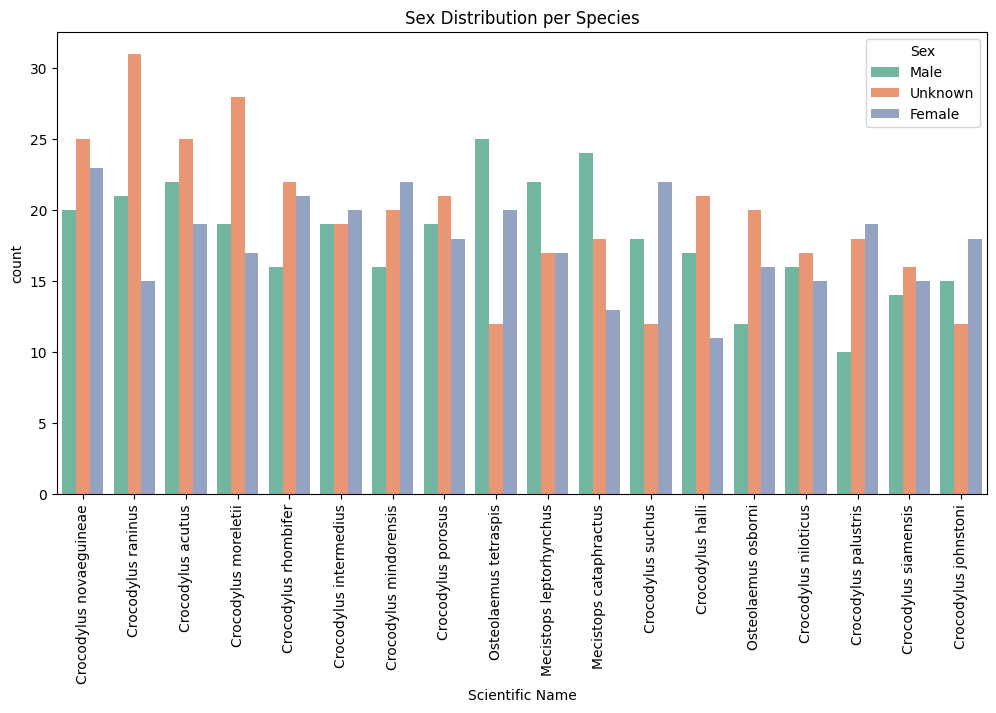

In [26]:
# 4. 종별 성별 분포

plt.figure(figsize=(12,6))
sns.countplot(x="Scientific Name", hue="Sex", data=df, palette="Set2", order=df["Scientific Name"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Sex Distribution per Species")
plt.show()

* 대부분의 종에서 Male/Female 비율이 큰 편향 없이 유지됨 -> 모델 학습 시 성별 불균형으로 인한 편향은 크지 않을 것으로 예상됨
* 일우 종에서 Unknown 비율이 높은 경우가 있음 -> 성별이 중요한 얘측 변수로 사용될 경우 Unknown 비율이 높은 종은 예측 오차가 커질 가능성이 있음

<Figure size 1200x600 with 0 Axes>

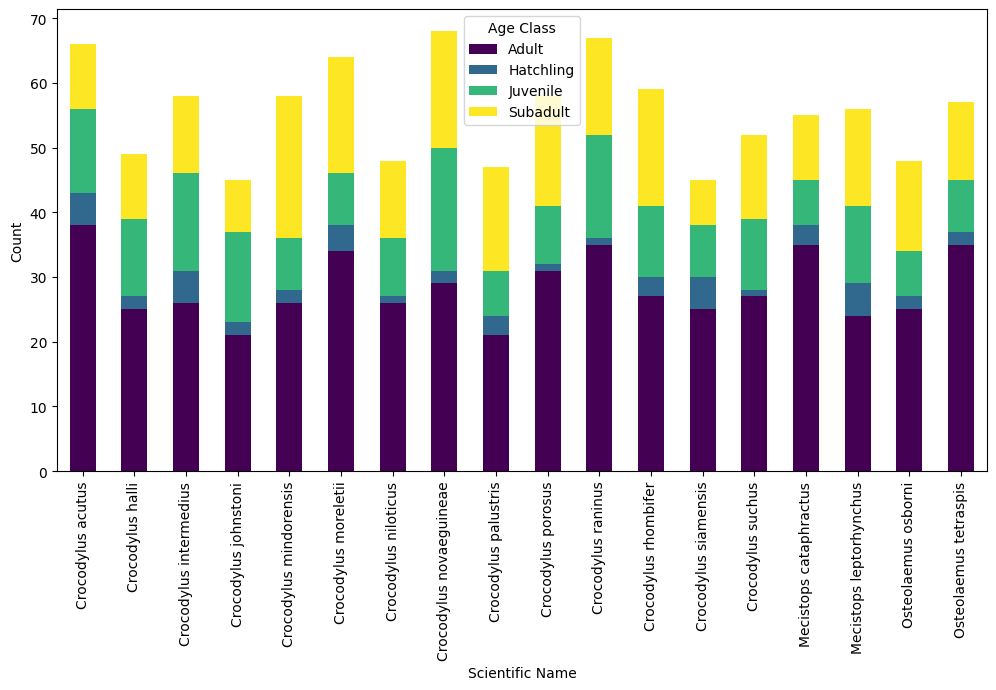

In [27]:
# 5. 종별 연령대 분포
plt.figure(figsize=(12,6))
age_species = pd.crosstab(df["Scientific Name"], df["Age Class"])
age_species.plot(kind="bar", stacked=True, figsize=(12,6), colormap="viridis")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

* 전체적으로 Adult 개체가 과대 표집되어 있음 -> 이는 야외 관찰 시 Adult가 더 쉽게 발견되거나 기록되었기 때문일 가능성이 큼
* 반면 Hatchling이나 Subadult는 매우 적은 수로 기록됨 -> 이는 생존률이 낮거나 서식지 접근성 한계로 인한 관찰 어려움으로 해석 가능

/tmp/ipython-input-2034276856.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Scientific Name", y="Observed Length (m)", data=df, palette="viridis")


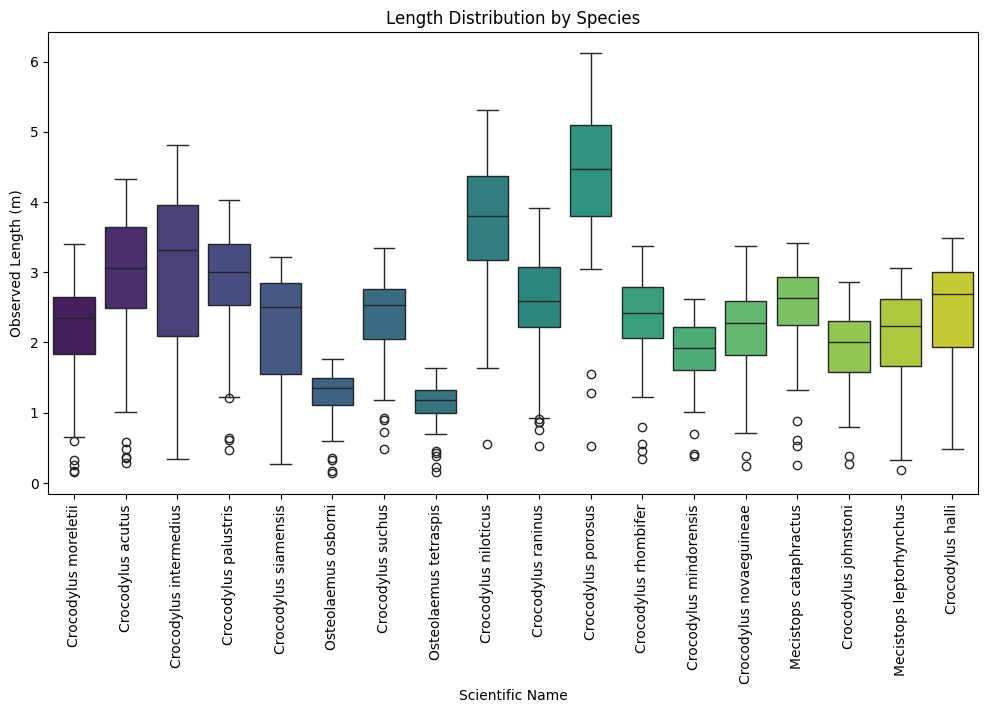

/tmp/ipython-input-2034276856.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Scientific Name", y="Observed Weight (kg)", data=df, palette="magma")


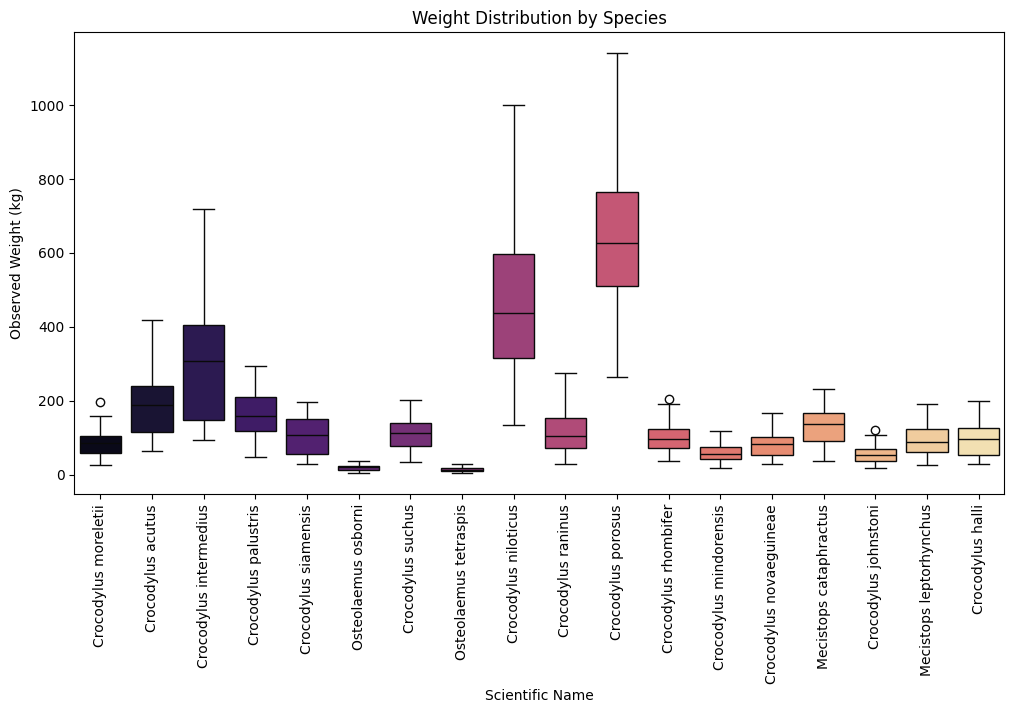

In [28]:
# 6. 종별 길이/무게 분포 (Boxplot)

plt.figure(figsize=(12,6))
sns.boxplot(x="Scientific Name", y="Observed Length (m)", data=df, palette="viridis")
plt.xticks(rotation=90)
plt.title("Length Distribution by Species")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x="Scientific Name", y="Observed Weight (kg)", data=df, palette="magma")
plt.xticks(rotation=90)
plt.title("Weight Distribution by Species")
plt.show()

* 종별 길이 분포에서 길이대의 크기 등에서 뚜렷한 차이가 보임 -> Observed Length가 종을 구분하는데 강력한 변수임을 시사
* 특정 종에서 5m 이상 개체가 존재하거나 극단적으로 짧은 개체들이 보임 -> 이는 데이터 내 개체별 다양성 혹은 관찰 오류/환경적 요인 가능성을 나타냄

* 일부 종은 전체적으로 높은 중앙값과 넓은 분포폭을 보임
* 일부 종은 상대적으로 무게 분포가 낮고 좁음

> 생물학적인 다양성일 수 있기때문에 이상치 제거는 신중히 접근

> 추후 모델링 전 로그변환 검토 가능





/tmp/ipython-input-4144700509.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Habitat Type", data=df, order=df["Habitat Type"].value_counts().index, palette="Set3")


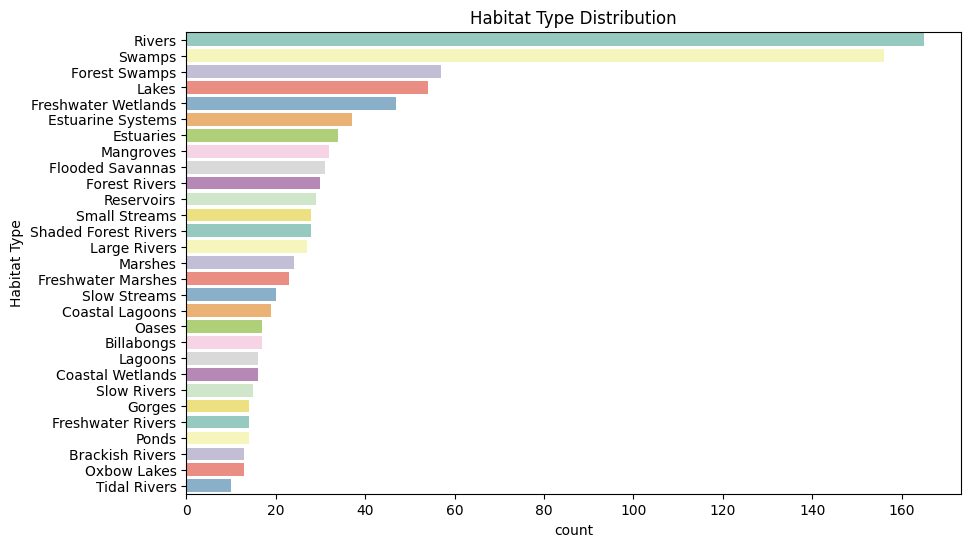

In [29]:
# 6. 서식지 분포

plt.figure(figsize=(10,6))
sns.countplot(y="Habitat Type", data=df, order=df["Habitat Type"].value_counts().index, palette="Set3")
plt.title("Habitat Type Distribution")
plt.show()


* Rivers와 Swamps가 가장 높은 비중을 차지



In [30]:
# 날짜 칼럼 datetime 변환
df["Date of Observation"] = pd.to_datetime(df["Date of Observation"], errors='coerce')

# 월 추출
df["Month"] = df["Date of Observation"].dt.month

# 계절 매핑
def month_to_season(month):
  if month in [3,4,5]:
    return "Spring"
  elif month in [6,7,8]:
    return "Summer"
  elif month in [9,10,11]:
    return "Autumn"
  elif month in [12,1,2]:
    return "Winter"
  else:
    return None

# 계절 칼럼 생성
df["Season"] = df["Month"].apply(month_to_season)

print(df[["Date of Observation", "Month", "Season"]].head())

               Date of Observation  Month  Season
Observation ID                                   
1                       2018-03-31      3  Spring
2                       2015-01-28      1  Winter
3                       2010-12-07     12  Winter
4                       2019-11-01     11  Autumn
5                       2019-07-15      7  Summer


/tmp/ipython-input-1681487889.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Date of Observation"] = pd.to_datetime(df["Date of Observation"], errors='coerce')


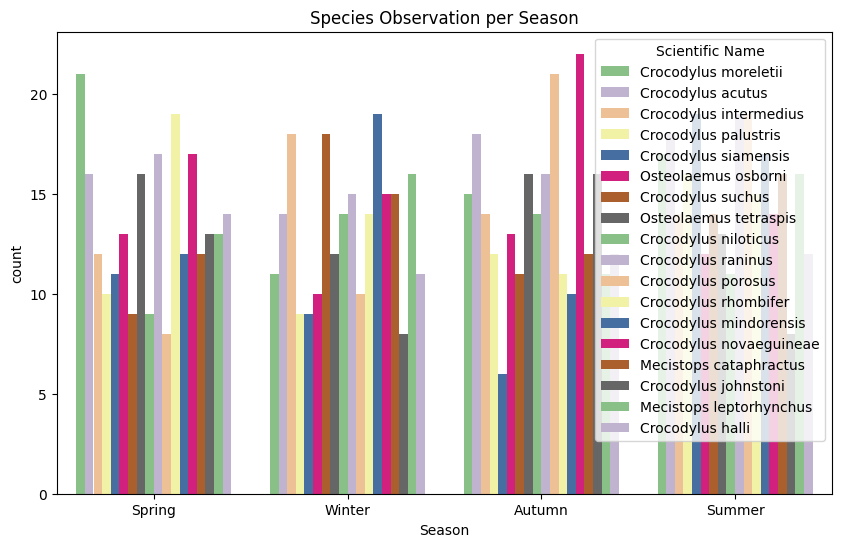

In [31]:
# 7. 계절별 종 분포

if "Season" in df.columns:
    plt.figure(figsize=(10,6))
    sns.countplot(x="Season", hue="Scientific Name", data=df, palette="Accent")
    plt.title("Species Observation per Season")
    plt.show()

* 전반적으로 큰 계절적 차이는 없음

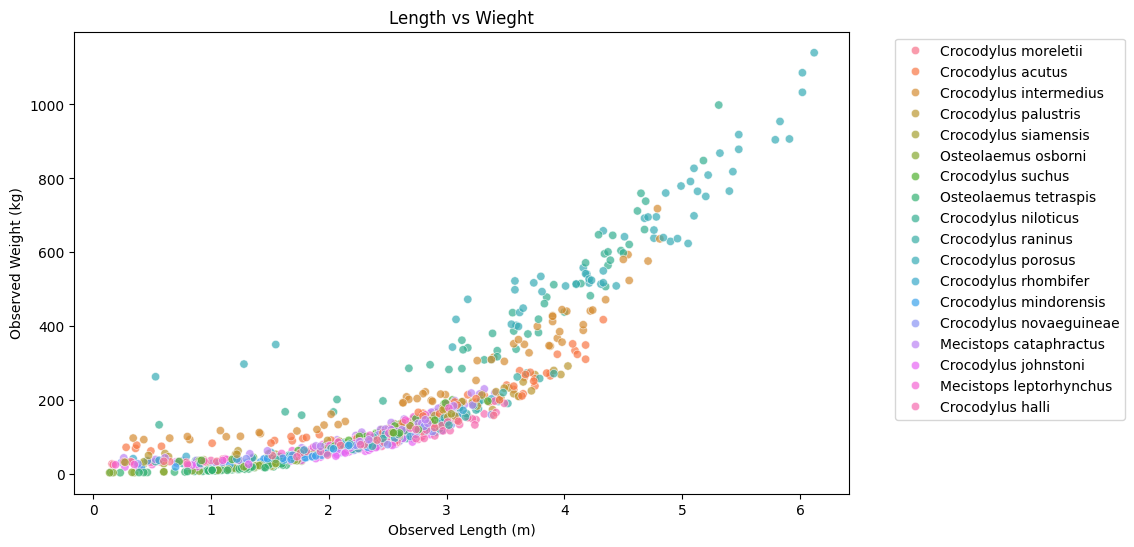

In [32]:
# 9. 종별 길이 vs 무게 산점도
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="Observed Length (m)",
    y="Observed Weight (kg)",
    hue="Scientific Name",
    alpha=0.7
)
plt.title("Length vs Wieght")
plt.legend(bbox_to_anchor=(1.05,1),loc="upper left")
plt.show()

* 전형적인 지수적 혹은 비선형적 관계(길이가 커질수록 무게가 급격히 증가하는 패턴)
* 색깔별 점 분포를 보면 대부분의 종이 유사한 성정 패턴을 따르지만 일부 종은 상대적으로 더 무겁거나 가벼운 경향이 있음

## 3. 데이터 전처리

In [33]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 로그 변환
df["log_length"] = np.log1p(df["Observed Length (m)"])
df["log_weight"] = np.log1p(df["Observed Weight (kg)"])

In [34]:
# Contry/Region 고유값 확인
unique_countries = df["Country/Region"].unique()
print(unique_countries)

['Belize' 'Venezuela' 'Mexico' 'India' 'Thailand'
 'Central African Republic' 'Sudan' 'Liberia' 'Cambodia' "Côte d'Ivoire"
 'Indonesia (Borneo)' 'Philippines' 'Malaysia (Borneo)' 'Tanzania'
 'Congo (DRC)' 'Cuba' 'Kenya' 'Pakistan' 'USA (Florida)'
 'Papua New Guinea' 'Australia' 'Senegal' 'South Africa' 'Guatemala'
 'Colombia' 'Sierra Leone' 'Indonesia (Papua)' 'Guinea' 'Nigeria'
 'Indonesia' 'Vietnam' 'Cameroon' 'Congo Basin Countries' 'Egypt' 'Mali'
 'Gabon' 'Malaysia' 'Niger' 'Costa Rica' 'Chad' 'Iran (historic)' 'Laos'
 'Ghana' 'Mauritania' 'Uganda' 'Sri Lanka' 'Nepal']


In [35]:
# 지역 단순화
region_map = {
    'Belize': 'Americas',
    'Venezuela': 'Americas',
    'Mexico': 'Americas',
    'Colombia': 'Americas',
    'Costa Rica': 'Americas',
    'Guatemala': 'Americas',
    'Cuba': 'Americas',
    'USA (Florida)': 'Americas',

    'Central African Republic': 'Africa',
    'Sudan': 'Africa',
    'Liberia': 'Africa',
    "Côte d'Ivoire": 'Africa',
    'Tanzania': 'Africa',
    'Congo (DRC)': 'Africa',
    'Kenya': 'Africa',
    'South Africa': 'Africa',
    'Sierra Leone': 'Africa',
    'Nigeria': 'Africa',
    'Guinea': 'Africa',
    'Cameroon': 'Africa',
    'Congo Basin Countries': 'Africa',
    'Egypt': 'Africa',
    'Mali': 'Africa',
    'Gabon': 'Africa',
    'Niger': 'Africa',
    'Chad': 'Africa',
    'Ghana': 'Africa',
    'Mauritania': 'Africa',
    'Uganda': 'Africa',

    'India': 'Asia',
    'Thailand': 'Asia',
    'Cambodia': 'Asia',
    'Philippines': 'Asia',
    'Pakistan': 'Asia',
    'Indonesia (Borneo)': 'Asia',
    'Malaysia (Borneo)': 'Asia',
    'Vietnam': 'Asia',
    'Malaysia': 'Asia',
    'Iran (historic)': 'Asia',
    'Laos': 'Asia',
    'Sri Lanka': 'Asia',
    'Nepal': 'Asia',

    'Papua New Guinea': 'Oceania',
    'Australia': 'Oceania',
    'Indonesia (Papua)': 'Oceania'
}

# Region_Simplifed 컬럼 생성
df['Region_Simplified'] = df['Country/Region'].map(region_map)

print(df[['Country/Region', 'Region_Simplified']].head(20))

                          Country/Region Region_Simplified
Observation ID                                            
1                                 Belize          Americas
2                              Venezuela          Americas
3                              Venezuela          Americas
4                                 Mexico          Americas
5                                  India              Asia
6                                  India              Asia
7                               Thailand              Asia
8               Central African Republic            Africa
9                                  Sudan            Africa
10                                Mexico          Americas
11                               Liberia            Africa
12                                Belize          Americas
13                              Cambodia              Asia
14                                Mexico          Americas
15                         Côte d'Ivoire            Afri

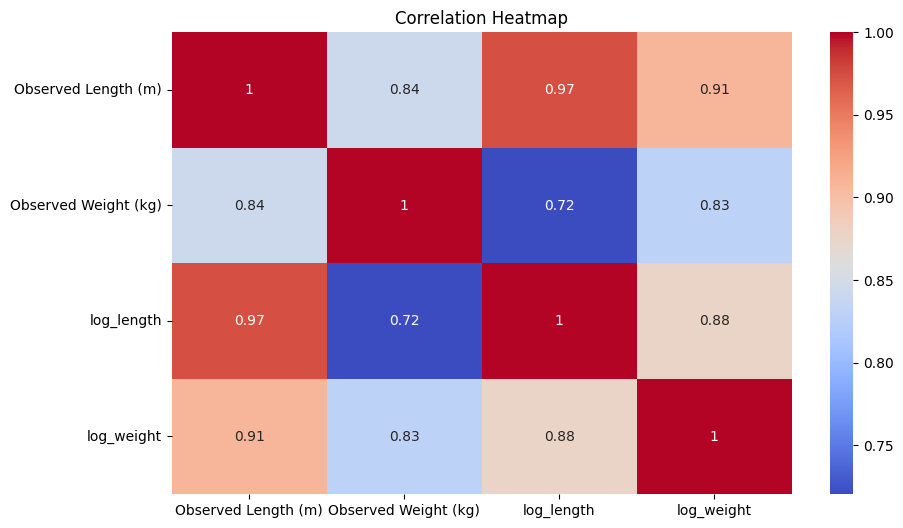

In [36]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[["Observed Length (m)", "Observed Weight (kg)", "log_length", "log_weight"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## 4. 모델링

### 데이터 분할
- 전체 데이터를 7:3으로 분할하여 각각 학습 데이터, 시험 데이터로 사용한다.

In [37]:
# Feature / Target 정의
features = ["log_length", "log_weight", "Age Class", "Sex", "Habitat Type", "Region_Simplified", "Conservation Status"]
target = "Scientific Name"

X = df[features]
y = df[target]

In [38]:
# 범주형 변수 인코딩
X = pd.get_dummies(X)

In [39]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

### 랜덤포레스트

In [40]:
# 모델 생성
rf = RandomForestClassifier(n_estimators=200, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=123)

In [41]:
# 예측
y_pred = rf.predict(X_test)

In [42]:
# 성능평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision(macro):", precision_score(y_test, y_pred, average="macro"))
print("Recall(macro):", recall_score(y_test, y_pred, average="macro"))
print("F1-score:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9633333333333334
Precision(macro): 0.965784832451499
Recall(macro): 0.9628695922813569
F1-score: 0.9637650834207506

Classification Report:
                          precision    recall  f1-score   support

      Crocodylus acutus       1.00      1.00      1.00        20
       Crocodylus halli       0.73      0.73      0.73        15
 Crocodylus intermedius       1.00      1.00      1.00        17
   Crocodylus johnstoni       1.00      1.00      1.00        14
 Crocodylus mindorensis       1.00      1.00      1.00        17
   Crocodylus moreletii       1.00      1.00      1.00        19
   Crocodylus niloticus       1.00      0.86      0.92        14
Crocodylus novaeguineae       0.76      0.80      0.78        20
   Crocodylus palustris       1.00      1.00      1.00        14
     Crocodylus porosus       1.00      0.94      0.97        17
     Crocodylus raninus       1.00      1.00      1.00        20
   Crocodylus rhombifer       1.00      1.00      1.00        18
 

* 정확도와 F1-Score가 모두 0.96 이상으로 매우 우수한 성능
* 대부분의 종에서 precision, recall, f1-score가 1.00으로 완벽하게 분류
* 일부 종에서 살짝 낮은 성능을 보임 -> 다른 종과 형태적 특징이 유사하거나 데이터 수가 적을 수 있음
* 데이터 보정 기법의 적용으로 데이터 불균형 문제를 해결해 볼 수 있음

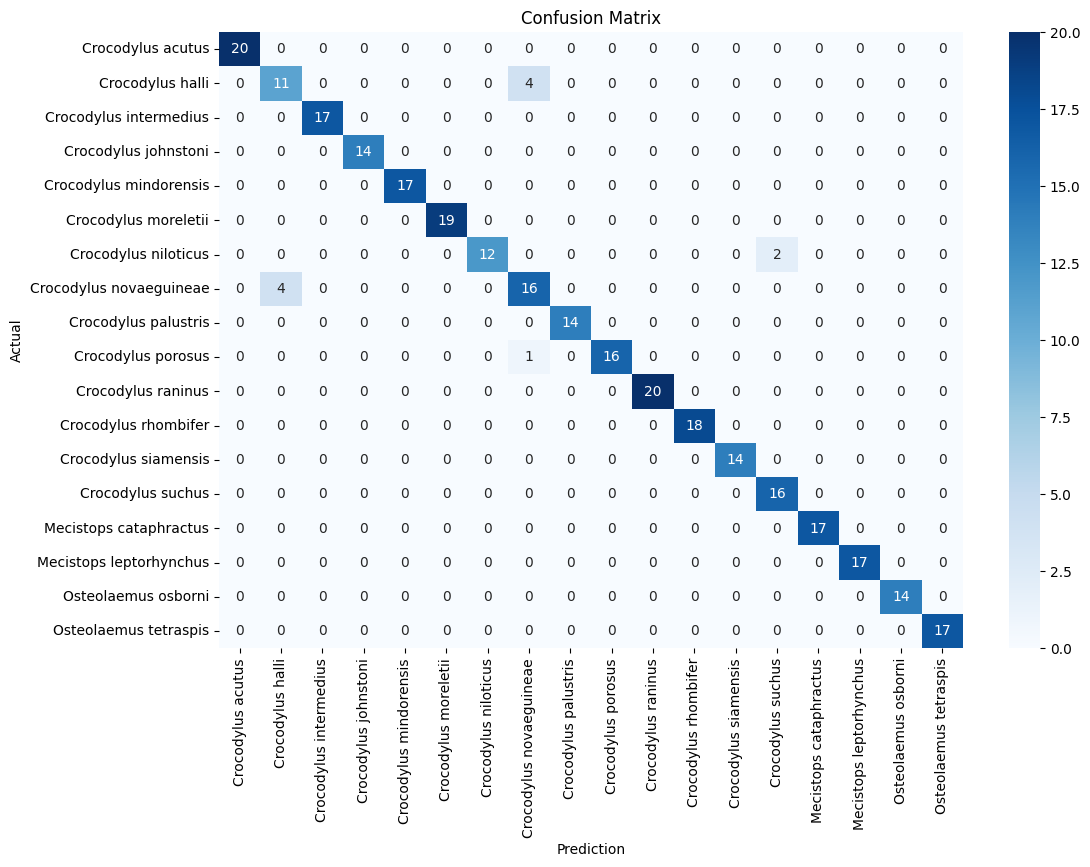

In [43]:
# Confution Matrix
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

* 대부분의 종이 대각선상에 완벽하게 정렬되어 있음 -> 올바르게 예측
* Crocodylus novaeguineae와 Crocodylus halli 구분에서만 약간의 혼동이 존재 -> 두 종의 외형적 특성이 매우 유사하거나 표본 수가 부족해 경계가 불분명한 것으로 추정
* soft voting 이나 stacking 기반 앙상블 등을 통해 개선 가능

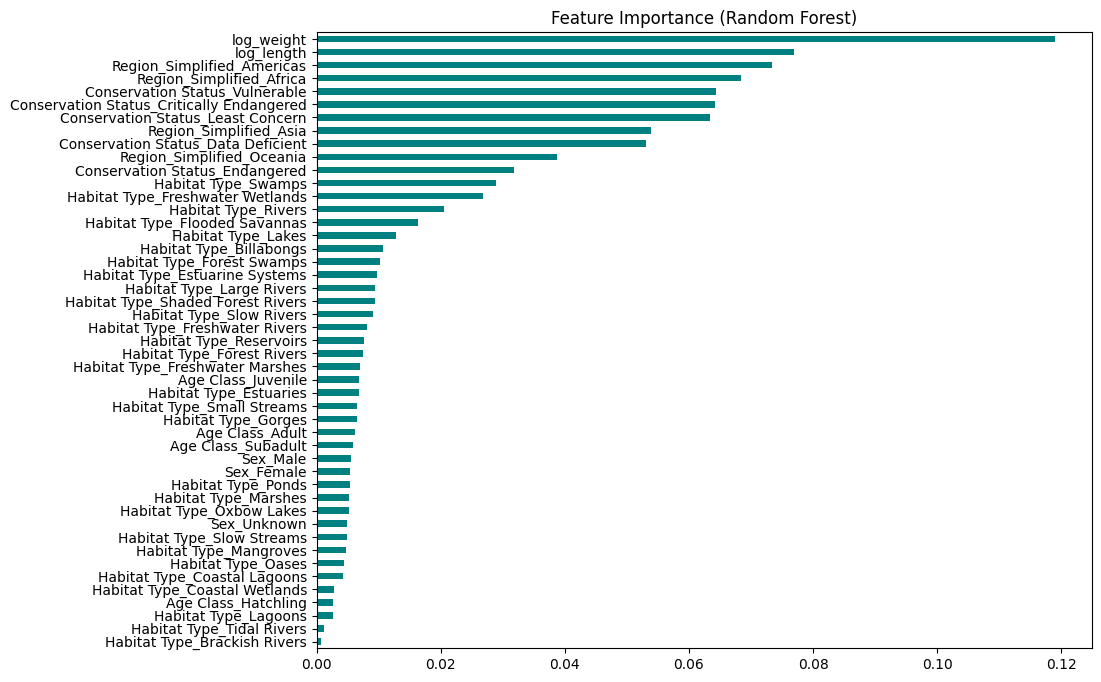

In [49]:
# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(10,8), color="teal")
plt.title("Feature Importance (Random Forest)")
plt.show()

* 길이와 무게가 종을 구분하는데 가장 핵심적인 역할 수행
* 지리적 정보도 중요한 역할 수행
* 보전 상태도 어느정도 주요한 역할 수행 (보전 상태가 지역, 서식지와 간접적으로 연결되어 있기 때문일 수도 있음)

### XGBoost

In [51]:
from xgboost import XGBClassifier

# 타겟 인코딩
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 모델 학습
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=123
)

xgb.fit(X_train, y_train_enc)

# 예측
y_pred_xgb = xgb.predict(X_test)

# 디코딩
y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)

# 성능평가
print("Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
print("Precision(macro):", precision_score(y_test_enc, y_pred_xgb, average="macro"))
print("Recall(macro):", recall_score(y_test_enc, y_pred_xgb, average="macro"))
print("F1-score:", f1_score(y_test_enc, y_pred_xgb, average="macro"))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_xgb))

Accuracy: 0.9836734693877551
Precision(macro): 0.9843508343508343
Recall(macro): 0.9835164835164836
F1-score: 0.9836469887427742

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.93      0.93      0.93        14
           2       0.93      1.00      0.97        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        13
           6       0.93      1.00      0.97        14
           7       0.92      0.92      0.92        13
           8       1.00      1.00      1.00        13
           9       1.00      0.93      0.96        14
          10       1.00      1.00      1.00        14
          11       1.00      0.92      0.96        13
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        14
          14       1.00      1.00  

* Random Forest에 비해 전반적으로 2~3% 정도 개선

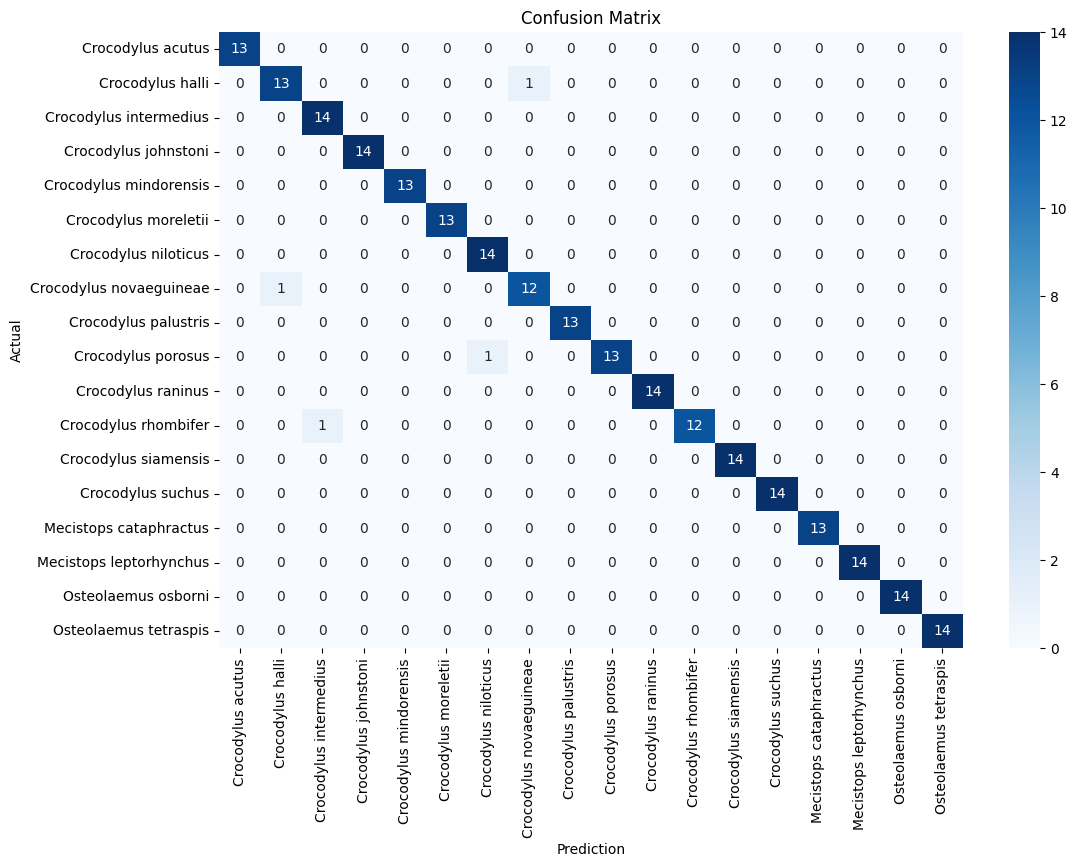

In [53]:
# Confution Matrix
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_labels), annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

* 대부분의 샘플이 정확히 자기 클래스로 분류됨
* 오차는 극히 일부 존재(자연스러운 노이즈 수준)